# Senticheck

_A simple sentiment classifier for the IMDb review dataset_

Here I shall go through the steps to train and test a simple LSTM-based sentiment classifier on the [IMDb review dataset](http://ai.stanford.edu/~amaas/data/sentiment/), first using Keras and then with TensorFlow.

In [1]:
%load_ext autoreload
%autoreload 2

In [93]:
import numpy as np
import pandas as pd
import re
import string
from utils import *

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from pandas_ml import ConfusionMatrix

### Data Preprocessing

I have written auxillary functions in `utils.py` to load the data into pandas dataframes.

In [ ]:
train_df = makeDF("./aclImdb/train")
test_df = makeDF("./aclImdb/test")

In [4]:
train_df.head()

,string,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,pos
1,Homelessness (or Houselessness as George Carli...,pos
2,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,This is easily the most underrated film inn th...,pos
4,This is not the typical Mel Brooks film. It wa...,pos


In [50]:
test_df.head()

,string,sentiment
0,I went and saw this movie last night after bei...,pos
1,Actor turned director Bill Paxton follows up h...,pos
2,As a recreational golfer with some knowledge o...,pos
3,"I saw this film in a sneak preview, and it is ...",pos
4,Bill Paxton has taken the true story of the 19...,pos


We first make a function to **clean unwanted characters** and numbers from the strings.

In [4]:
def clean_string(sample):
    cleaner = re.compile('<.*?>') # rm characters within <>
    sample = re.sub(r'\d+', '', sample) # rm one or more digits
    sample = re.sub(cleaner, '', sample)
    sample = re.sub("'", '', sample) # rm single quotes
    sample = re.sub(r'\W+', ' ', sample) # rm non-word characters
    sample = sample.replace('_', '') # rm underscores
    sample = sample.lower() # make lowercase
    return sample

In [198]:
print('Uncleaned String:', '\n \n', train_df.loc[10, 'string'][:501],'\n', sep='')
print('Cleaned String:', '\n \n', clean_string(train_df.loc[10, 'string'][:501]), sep='')

Uncleaned String:
 
When I first read Armistead Maupins story I was taken in by the human drama displayed by Gabriel No one and those he cares about and loves. That being said, we have now been given the film version of an excellent story and are expected to see past the gloss of Hollywood...<br /><br />Writer Armistead Maupin and director Patrick Stettner have truly succeeded! <br /><br />With just the right amount of restraint Robin Williams captures the fragile essence of Gabriel and lets us see his struggle with

Cleaned String:
 
when i first read armistead maupins story i was taken in by the human drama displayed by gabriel no one and those he cares about and loves that being said we have now been given the film version of an excellent story and are expected to see past the gloss of hollywood writer armistead maupin and director patrick stettner have truly succeeded with just the right amount of restraint robin williams captures the fragile essence of gabriel and lets us see his 

This processing extracts the information we want from the strings (the words and their contexts amongst the other words), whilst also ensuring that words with different formatting are detected as the same _e.g._ `"When" = "when"`, `"loves." = "loves"`.

Now we need to process the input data. I will encode each string as an array of integers, only the most popular words (up to `vocab_size` below) will be kept, the others are dropped. I normally use sklearn's `LabelEncoder()` for this purpose, but the `Tokenizer()` in Keras seems to be much easier / more efficient.

In [153]:
# Clean samples
X_tr = train_df['string'].apply(lambda x: clean_string(x)).values
X_te = test_df['string'].apply(lambda x: clean_string(x)).values

# Create tokenizer
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, split=' ') 
tokenizer.fit_on_texts(X_tr)

# Integer-encode
X_tr = np.array(tokenizer.texts_to_sequences(X_tr))
X_te = np.array(tokenizer.texts_to_sequences(X_te))

Looking into the distribution of review lengths in greater detail.

In [299]:
from matplotlib import pyplot

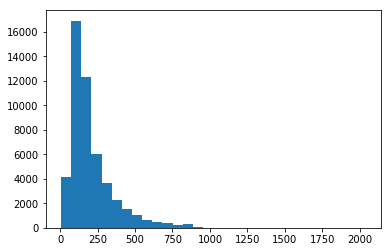

In [316]:
_ = plt.hist(lengths,30)

In [310]:
lengths = np.array([[len(x) for x in X_tr],[len(x) for x in X_te]]).flatten()
print('Mean review-length: %.0f words' % mean_length.mean())

Mean review-length: 207 words


We can see that most fall below 250 words in length.

Ideally, we'd take the full reviews for training, however, this would take far too long on my machine. I've chosen to take the first 32 words instead. Any samples _shorter_ than this length are padded with 0 to ensure uniform sequence length so that we can input the data into our NN.

In [154]:
# Padding
# maxlen = max([max([len(x) for x in X_tr]),max([len(x) for x in X_te])])
maxlen = 32 # only take the first 32 words for the sake of speed
X_train = pad_sequences(X_tr, maxlen=maxlen)
X_test = pad_sequences(X_te, maxlen=maxlen)

Now we shall convert the pos/neg column into a binary token 0/1.

In [155]:
Y_train = pd.get_dummies(train_df['sentiment']).values
Y_test = pd.get_dummies(test_df['sentiment']).values

In [156]:
print('X_train shape:', X_train.shape, '\n', 'X_test shape:', X_test.shape)
print('Y_train shape:', Y_train.shape, '\n', 'Y_test shape:', Y_test.shape)

X_train shape: (25000, 32) 
 X_test shape: (25000, 32)
Y_train shape: (25000, 2) 
 Y_test shape: (25000, 2)


The train/test split has already been carried out but we need to now split the test data into the validation/test data.

In [157]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=1)

# Keras

I roughly followed the approach taken [here](http://bit.ly/2O4PNEd). The author applies a Recurrent Neural Network with LSTM units to predict the (positive/negative) sentiment of tweets. My problem is essentially the same, except the IMDb dataset I am using contains longer strings for each sample, hence why I have cut down my sequence length above to cut down on computation time.

An RNN is an obvious choice of architecture if we are applying deep learning to sentiment analysis of text, as it captures the inherent sequential aspect of language; it has time-dependence. However, traditional RNN's suffer from the problem of vanishing/exploding gradients during training, where the weight matrix becomes unstable.

For this reason I'm using LSTM units, which attempt to address this by introducing a number of gates. These, in part, help each unit to determine which previous states will contribute towards the value of the current state. They have been shown to work well in this context. 

### Model

I added a second hidden LSTM layer to try and capture deeper dependencies between the words. I have also increased the dropout since the model was overfitting.

In [158]:
embed_dim = 128 # nodes in the embedding layer
lstm_out = 196 # nodes in the lstm layer

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = X_train.shape[1])) # layer for word vectorisation
model.add(SpatialDropout1D(0.6)) # prevent overfitting
model.add(LSTM(lstm_out, dropout=0.6, recurrent_dropout=0.6, return_sequences=True)) # LSTM layer 1
model.add(LSTM(lstm_out, dropout=0.6, recurrent_dropout=0.6)) # LSTM layer 2
model.add(Dense(2,activation='softmax')) # softmax layer
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 32, 128)           640000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 32, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32, 196)           254800    
_________________________________________________________________
lstm_6 (LSTM)                (None, 196)               308112    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 394       
Total params: 1,203,306
Trainable params: 1,203,306
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [159]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 1, validation_data=(X_val, Y_val))

Train on 25000 samples, validate on 12500 samples
Epoch 1/5
25000/25000 [==============================] - 92s 4ms/step - loss: 0.5966 - acc: 0.6706 - val_loss: 0.4907 - val_acc: 0.7764
Epoch 2/5
25000/25000 [==============================] - 90s 4ms/step - loss: 0.4947 - acc: 0.7658 - val_loss: 0.4550 - val_acc: 0.7855
Epoch 3/5
25000/25000 [==============================] - 85s 3ms/step - loss: 0.4591 - acc: 0.7894 - val_loss: 0.4516 - val_acc: 0.7879
Epoch 4/5
25000/25000 [==============================] - 88s 4ms/step - loss: 0.4371 - acc: 0.8018 - val_loss: 0.4512 - val_acc: 0.7869
Epoch 5/5
25000/25000 [==============================] - 85s 3ms/step - loss: 0.4195 - acc: 0.8119 - val_loss: 0.4432 - val_acc: 0.7933


### Testing

In [160]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Accuracy: %.2f" % (acc))

Score: 0.44
Accuracy: 0.79


[This](https://blog.paralleldots.com/data-science/breakthrough-research-papers-and-models-for-sentiment-analysis/) article runs through some of the accuracies scored on the IMDb benchmark. Given the size of reviews we used, we haven't performed too poorly.

Let's build a confusion matrix.

In [164]:
mask = Y_test == 1
Y_results = np.tile(np.array(['pos', 'neg']), (mask.shape[0],1))[mask]

Y_pred_results = model.predict(X_test)
Y_pred_results = np.array(['pos', 'neg'])[np.argmax(Y_pred_results, axis=1)]

In [165]:
results = pd.DataFrame(np.array([Y_results, Y_pred_results]).T, columns=['Actual', 'Predicted'])

In [166]:
results.head()

,Actual,Predicted
0,pos,pos
1,pos,pos
2,pos,pos
3,neg,neg
4,pos,pos


In [168]:
confusion_matrix = ConfusionMatrix(np.where(results['Actual']=='pos',True,False), np.where(results['Predicted']=='pos',True,False))
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False       4961  1225     6186
True        1370  4944     6314
__all__     6331  6169    12500


Where True/False represent positive/negative sentiments respectively.

In [199]:
pos = results[results['Actual'] == 'pos']
pos_acc = (pos['Actual'] == pos['Predicted']).sum()/pos.shape[0]

neg = results[results['Actual'] == 'neg']
neg_acc = (neg['Actual'] == neg['Predicted']).sum()/neg.shape[0]

print('Positive Accuracy: ', pos_acc, '\n', 'Negative Accuracy: ', neg_acc, sep='')

Positive Accuracy: 0.7830218561925879
Negative Accuracy: 0.8019721952796638


So we see a slightly better performance identifying negative reviews, although we'd have to run multiple tests to determine whether this is statistically significant.

### Example Errors

Let's look at some examples of the strings it predicted wrong.

In [170]:
error_inds = np.argwhere(results['Actual'] != results['Predicted']).flatten()
error_inds

array([    6,     7,    13, ..., 12491, 12494, 12498])

In [171]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [178]:
def print_example(index, reverse_word_map, results):
    err_ind = index
    print('Actual: ', results.loc[err_ind, 'Actual'],'\n','Predicted: ',results.loc[err_ind, 'Predicted'],sep='')
    err = [reverse_word_map[x] for x in X_test[err_ind]]
    print('Text:')
    print(' '.join(err))
    return

In [201]:
for i in range(5):
    print(i+1,'.',sep='')
    print_example(error_inds[i], reverse_word_map, results)
    print('\n')

1.
Actual: neg
Predicted: pos
Text:
white cinematography but available in a horrible version adequate music score fitting to suspense by frank the motion picture is r william the usual saga director and in the monsters movies universal


2.
Actual: pos
Predicted: neg
Text:
but ultimately not recommended and whats with the lack of an dvd i know it was shot in because i saw the pilot episode on one of our channels get with the


3.
Actual: neg
Predicted: pos
Text:
because i hate it when people give spoilers so i do not want to be one of those people well i guess that is all i have to say about this movie


4.
Actual: neg
Predicted: pos
Text:
work and an exciting climax its been said that the running time on this one was when it showed in india of robert a master at given a choice for the version


5.
Actual: neg
Predicted: pos
Text:
typically american the actors performance is ok sandra usually me with her oh my god why me way to behave but this time she seems to have herself id recommen

There are a couple of things to note from these examples:

- It is evident that longer samples would be desireable. Some of samples above (e.g. 2) would be difficult to predict even for a human, more context is needed.
- The `vocab_size` of 5000 that I used seems a little small. At least to a human, the sentences seem disjointed due to the dropped words. Perhaps increasing the vocab size would increase accuracy (although it was unclear during testing whether changing `vocab_size` did make a noticeable difference). 

### Correct Examples

Let's look at some of the samples that the model predicted _correctly_.

In [189]:
corr_inds = np.argwhere(results['Actual'] == results['Predicted']).flatten()

In [188]:
for i in range(5):
    print(i+1,'.',sep='')
    print_example(corr_inds[i], reverse_word_map, results)
    print('\n')

1.
Actual: pos
Predicted: pos
Text:
plain common sense would ever do that i guess the actor figured that his level the longer he holds the gun that way this movie is such an insult to common sense


2.
Actual: pos
Predicted: pos
Text:
for me if you get a chance to watch the mstk version you wont be disappointed by it self not so much but i can think of worse methods of torture anyone


3.
Actual: pos
Predicted: pos
Text:
around is yet another poorly made film about spirits attempting to warn people away from a house if theres any message that the delivers its dont waste your time on this movie


4.
Actual: neg
Predicted: neg
Text:
also made in mexico several years later it deals with a similar subject matter the of the ego in the face of only it does so in a funny and totally style


5.
Actual: pos
Predicted: pos
Text:
interesting unfortunately the dialogue wasnt really there for them im giving it a for their performances but nothing else here is worth mentioning hopefully these actors

Interestingly, some of these samples I would have predicted _incorrectly_ (e.g. 1, 3). It's difficult to tell if the model is just 'lucky' in these cases or whether it actually has a deeper statistical understanding of the reviews. Otherwise, the results are as one might expect (e.g. 2, 5).

### Model Summary

Thoughts for future improvements:

- Train the network on a larger sequence of each review
- Use a larger vocab
- Perhaps try using a CNN - have been shown to work well on movie reviews [here](https://www.aclweb.org/anthology/D14-1181)

# Tensorflow

Let's try building a similar model but using pure Tensorflow, this time with only one layer of LSTM cells. I am following the (modified) approach for implementing LSTMs in Tensorflow from [here](https://bit.ly/2DOGvYh) and [here](https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow).

In [203]:
import tensorflow as tf

### Data

We first need to create a class which will let us store our data as an object. It has simple methods to shuffle the data and to return batches iteratively, these will be used in training.

In [272]:
class SimpleDataIterator():
    def __init__(self, data):
        self.data = data
        self.size = data[0].shape[0]
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        s = np.arange(self.data[0].shape[0])
        np.random.shuffle(s)
        self.data = [self.data[0][s],self.data[1][s]]
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor+n-1 > self.size:
            self.epochs += 1
            self.shuffle()
        X_batch = self.data[0][self.cursor:self.cursor+n]
        Y_batch = self.data[1][self.cursor:self.cursor+n]
        self.cursor += n
        return X_batch, Y_batch, np.array(n*[X_batch.shape[1]])

In [220]:
# Convert Y from one-hot encoded to integer encoded
train = [X_train, np.argmax(Y_train, axis=1)] 
val = [X_val, np.argmax(Y_val, axis=1)]
test = [X_test, np.argmax(Y_test, axis=1)]

### Model

In [276]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

def build_graph(
    vocab_size = vocab_size,
    state_size = 64,
    batch_size = 32,
    num_classes = 2):

    reset_graph()

    # Placeholders
    x = tf.placeholder(tf.int32, shape=[batch_size, None]) # [batch_size, num_steps]
    seqlen = tf.placeholder(tf.int32, shape=[batch_size])
    y = tf.placeholder(tf.int32, shape=[batch_size])
    keep_prob = tf.placeholder(tf.float32,[])

    # Embedding layer
    embeddings = tf.get_variable('embedding_matrix', shape=[vocab_size, state_size])
    rnn_inputs = tf.nn.embedding_lookup(embeddings, x)

    # LSTM
    lstmCell = tf.contrib.rnn.BasicLSTMCell(state_size)
    lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=keep_prob)
    rnn_outputs, _ = tf.nn.dynamic_rnn(lstmCell, rnn_inputs, dtype=tf.float32)
    

    # Add dropout, as the model otherwise quickly overfits
    rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)

    idx = tf.range(batch_size)*tf.shape(rnn_outputs)[1] + (seqlen - 1)
    last_rnn_output = tf.gather(tf.reshape(rnn_outputs, [-1, state_size]), idx)

    # Softmax layer
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes])
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    logits = tf.matmul(last_rnn_output, W) + b
    preds = tf.nn.softmax(logits)
    correct = tf.equal(tf.cast(tf.argmax(preds,1),tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

    return {
        'x': x,
        'seqlen': seqlen,
        'y': y,
        'dropout': keep_prob, # should change this to keep_prob rather than dropout, it's confusing
        'loss': loss,
        'ts': train_step,
        'preds': preds,
        'accuracy': accuracy
    }

### Training

In [286]:
def train_graph(graph, batch_size = 32, num_epochs = 5, iterator = SimpleDataIterator):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tr = iterator(train)
        va = iterator(val)
        g = graph

        step, accuracy = 0, 0
        tr_losses, te_losses = [], []
        current_epoch = 0
        while current_epoch < num_epochs:
            step += 1
            batch = tr.next_batch(batch_size)
            feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 0.6}
            accuracy_, _ = sess.run([g['accuracy'], g['ts']], feed_dict=feed)
            accuracy += accuracy_

            if tr.epochs > current_epoch:
                current_epoch += 1
                tr_losses.append(accuracy / step)
                step, accuracy = 0, 0

                #val set accuracy
                te_epoch = va.epochs
                while va.epochs == te_epoch:
                    step += 1
                    batch = va.next_batch(batch_size)
                    feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 0.6}
                    accuracy_ = sess.run([g['accuracy']], feed_dict=feed)[0]
                    accuracy += accuracy_

                te_losses.append(accuracy / step)
                step, accuracy = 0,0
                print("Accuracy after epoch", current_epoch, " - acc:", tr_losses[-1], "- val_acc:", te_losses[-1])

    return tr_losses, te_losses

In [287]:
g = build_graph()
tr_losses, te_losses = train_graph(g)

Accuracy after epoch 1  - acc: 0.654891304347826 - val_acc: 0.7559942455242967
Accuracy after epoch 2  - acc: 0.7873319462227913 - val_acc: 0.7741185897435897
Accuracy after epoch 3  - acc: 0.814940781049936 - val_acc: 0.7791666666666667
Accuracy after epoch 4  - acc: 0.8315861075544174 - val_acc: 0.7808493589743589
Accuracy after epoch 5  - acc: 0.8421494878361075 - val_acc: 0.7738782051282052


I didn't have time to implement a proper evaluation of this model's accuracy, but we can see that on the validation dataset the model performance is almost on par with my Keras model with two LSTM layers. The limiting factor for further accuracy improvements is, as before, likely to be the short sequence-length.

There may be some overfitting occurring in the final epoch as the validation dataset accuracy reduces, this persisted despite me tuning the `keep_prob` (`keep_prob = 1 - dropout_prob`). 